# kCCA Tutorial with UCI Digits Dataset

In this example, kCCA is used to project different views of a UCI dataset with handwritten digits into a common latent space. All of the views have 2000 samples. We will only be using the first two views in this tutorial. View 1 has 76 dimensions and View 2 has 216 dimensions.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../../..")
import numpy as np
from scipy import linalg, stats

from multiview.embed.kcca import KCCA
from multiview.datasets.base import load_UCImultifeature

data = load_UCImultifeature()
views = data[0]
view_1 = views[0]
view_2 = views[1]
labels = data[1]

# Center Data
view_1 = stats.zscore(view_1, axis=1, ddof=1)
mu1 = np.mean(view_1, axis=0)
view_1 -= mu1

view_2 = stats.zscore(view_2, axis=1, ddof=1)
mu2 = np.mean(view_2, axis=0)
view_2 -= mu2

## Linear Kernel

In [2]:
# Create a linear kcca object as an instantiation of the KCCA object class
kcca_l = KCCA(ktype ="linear", reg = 0.0001, numCC = 2)

# Use the train() method to find a linear projection between the two views.
kcca_l.fit([view_1, view_2])

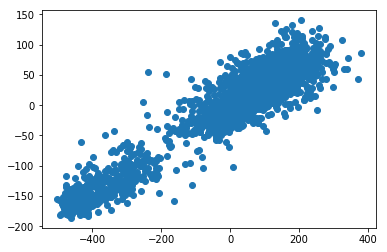

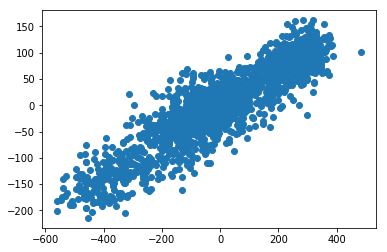

In [3]:
# Plot component 1 of view 1 and 2 into common subspace. 
# Should be a linear correlation as kcca aims to maximize the linear correlation
fig = plt.figure()
plt.scatter(kcca_l.comps_[0][:,0],kcca_l.comps_[1][:,0])

# Plot component 2 of view 1 and 2 into common subspace.
fig = plt.figure()
plt.scatter(kcca_l.comps_[0][:,1],kcca_l.comps_[1][:,1])

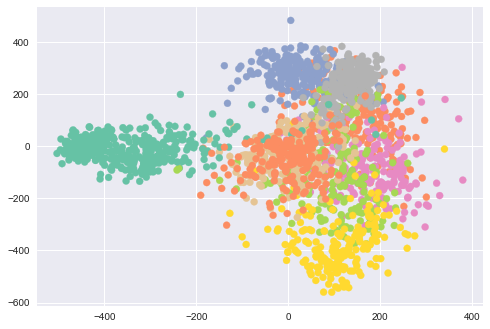

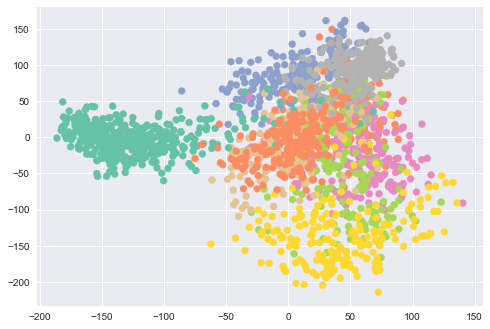

In [4]:
plt.style.use('seaborn')

color_map = [sns.color_palette("Set2", 10)[int(i)] for i in labels]

# Plot component 1 and 2 of view 1 and component 1 and 2 of view 2. Should be a similar shape.
fig = plt.figure()
plt.scatter(kcca_l.comps_[0][:,0],kcca_l.comps_[0][:,1], label = labels, color=color_map)
fig = plt.figure()
plt.scatter(kcca_l.comps_[1][:,0],kcca_l.comps_[1][:,1], label = labels, color=color_map)

In [5]:
# Call cancorrs_ to find the correlation between the two canonical components
kcca_l.cancorrs_

array([0.93547673, 0.89607794])

# Polynomial kCCA

In [18]:
# Create a polynomial kcca object as an instantiation of the KCCA object class
kcca_p5 = KCCA(ktype ="poly", reg = 0.0001, numCC = 2, degree = 3)

# Use the train() method to find a polynomial projection between the two views.
kcca_p5.fit([view_1, view_2])

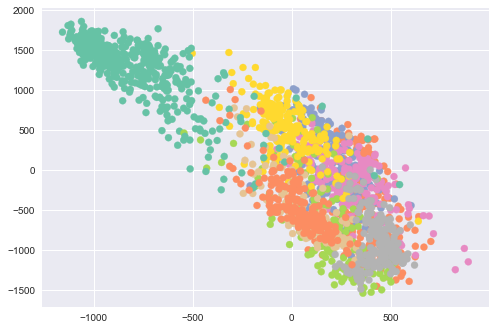

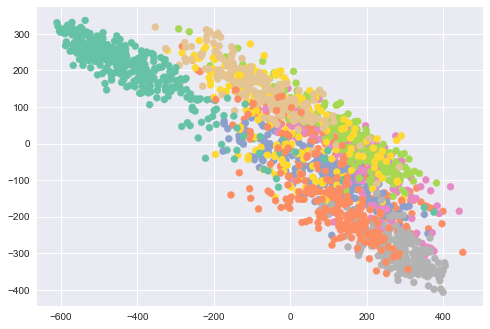

In [20]:
fig = plt.figure()
plt.scatter(kcca_p5.comps_[0][:,0],kcca_p5.comps_[0][:,1], label = labels, color=color_map)
fig = plt.figure()
plt.scatter(kcca_p5.comps_[1][:,0],kcca_p5.comps_[1][:,1], label = labels, color=color_map)

In [8]:
# Call cancorrs_ to find the correlation between the two canonical components
kcca_p5.cancorrs_

array([-0.20208208,  0.83292596])

## Gaussian Kernel

In [28]:
# Create a gaussian kcca object as an instantiation of the KCCA object class
kcca_g = KCCA(ktype ="gaussian", reg = 0.0001, numCC = 2, gausigma = 2)

# Use the train() method to find a gaussian projection between the two views.
kcca_g.fit([view_1, view_2])

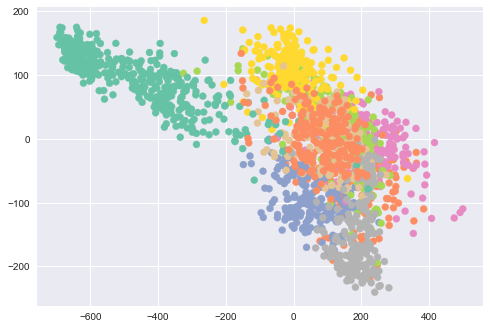

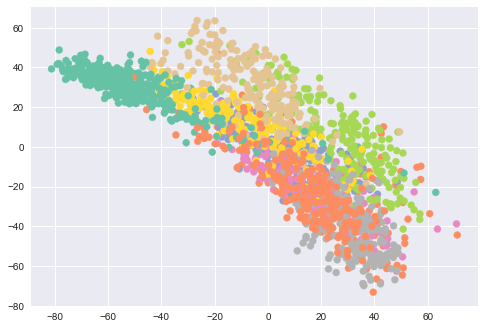

In [29]:
# Plot component 1 and 2 of view 1 and component 1 and 2 of view 2. Should be a similar shape.
fig = plt.figure()
plt.scatter(kcca_g.comps_[0][:,0],kcca_g.comps_[0][:,1], label = labels, color=color_map)
fig = plt.figure()
plt.scatter(kcca_g.comps_[1][:,0],kcca_g.comps_[1][:,1], label = labels, color=color_map)

In [25]:
# Call cancorrs_ to find the correlation between the two canonical components
kcca_g.cancorrs_

array([0.81150926, 0.63423257])

In [12]:
# If you are splitting test data into training and testing datasets, you can use 
# train() on the training dataset and then using validate() on the testing dataset.
# validate() will use the canonical weights on the testing data to bring the test data
# into the projected shared space.

## Plotting Together

In [13]:
list_x = [[kcca_l.comps_[0][:,0], kcca_p5.comps_[0][:,0], kcca_g.comps_[0][:,0]],
          [kcca_l.comps_[1][:,0], kcca_p5.comps_[1][:,0], kcca_g.comps_[1][:,0]]]
list_y = [[kcca_l.comps_[0][:,1], kcca_p5.comps_[0][:,1], kcca_g.comps_[0][:,1]],
          [kcca_l.comps_[1][:,1], kcca_p5.comps_[1][:,1], kcca_g.comps_[1][:,1]]]

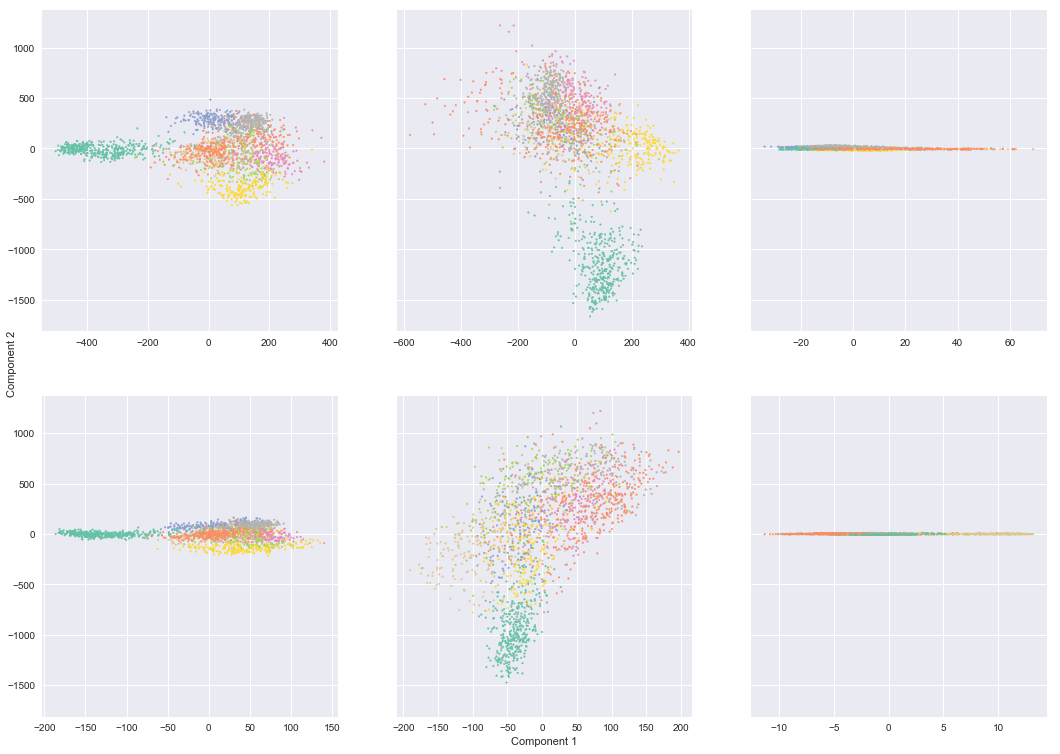

In [30]:
fig, axes = plt.subplots(2,3,figsize=(18,13), sharey=True)

for i in range(2):
    for j in range(3):
            axes[i,j].scatter(x=list_x[i][j], y=list_y[i][j], alpha=1, label=labels, color=color_map, s=3)

ax = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.grid(False)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

# Applying model to test data

In [4]:
nSamples = 2000
train1 = view_1[:nSamples//2]
train2 = view_2[:nSamples//2]
test1 = view_1[nSamples//2:]
test2 = view_2[nSamples//2:]

#Create a linear kcca object as an instantiation of the KCCA object class
tkcca_l = KCCA(ktype ="linear", reg = 0.0001, numCC = 2)

# Use the train() method to find a linear projection between the two views.
tkcca_l.fit([train1, train2])

# Apply model to test data to get canonical components and correlations between actual
# test data and predictions obtained by projecting the other test dataset
# via the CCA mapping for each dimension
testcomps, testcorrs = tkcca_l.fit_transform([test1, test2])